In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('dataset.csv')
print(df.head())
df = df.dropna() 

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to extract top keywords using TF-IDF
def extract_keywords(text_series, n_keywords=7):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=n_keywords)
    tfidf_matrix = vectorizer.fit_transform(text_series)
    keywords = vectorizer.get_feature_names_out()
    return keywords, tfidf_matrix

# Extract keywords for RootCause
root_cause_keywords, root_cause_tfidf = extract_keywords(df['RootCause'])
print("Root Cause Keywords:", root_cause_keywords)

# Extract keywords for IncidentSummary
incident_summary_keywords, incident_summary_tfidf = extract_keywords(df['IncidentSummary'])
print("Incident Summary Keywords:", incident_summary_keywords)

# Extract keywords for ResolutionText
resolution_text_keywords, resolution_text_tfidf = extract_keywords(df['ResolutionText'])
print("Resolution Text Keywords:", resolution_text_keywords)


Root Cause Keywords: ['bug' 'failure' 'issue' 'network' 'outage' 'power' 'spam']
Incident Summary Keywords: ['database' 'hours' 'issue' 'network' 'outage' 'peak' 'server']
Resolution Text Keywords: ['faulty' 'fixed' 'replaced' 'restarted' 'restored' 'server' 'user']


In [70]:
# Convert TF-IDF matrices to DataFrames
root_cause_df = pd.DataFrame(root_cause_tfidf.toarray(), columns=[f'RC_{word}' for word in root_cause_keywords])
incident_summary_df = pd.DataFrame(incident_summary_tfidf.toarray(), columns=[f'IS_{word}' for word in incident_summary_keywords])
resolution_text_df = pd.DataFrame(resolution_text_tfidf.toarray(), columns=[f'RT_{word}' for word in resolution_text_keywords])

# Combine the keyword features with the original DataFrame
df_keywords = pd.concat([df, root_cause_df, incident_summary_df, resolution_text_df], axis=1)

# Drop original text columns
df_keywords.drop(columns=['IncidentSummary', 'ResolutionText', 'RootCause'], inplace=True)

# Display the first few rows of the new DataFrame
print(df_keywords)


    HoursOfDowntime  OverallSeverity  CompanyAccountability  \
18         2.432828                2                      0   
61         4.013420                1                      1   
28         2.246557                4                      1   
60         1.007889                2                      0   
52         4.010673                3                      1   

    Department_DevOps  Department_IT  Department_Ops  Department_Security  \
18              False          False           False                 True   
61              False          False           False                 True   
28               True          False           False                False   
60              False           True           False                False   
52              False          False            True                False   

    PlatformType_Cloud  PlatformType_Database  PlatformType_Hardware  ...  \
18               False                  False                   True  ...   
61  

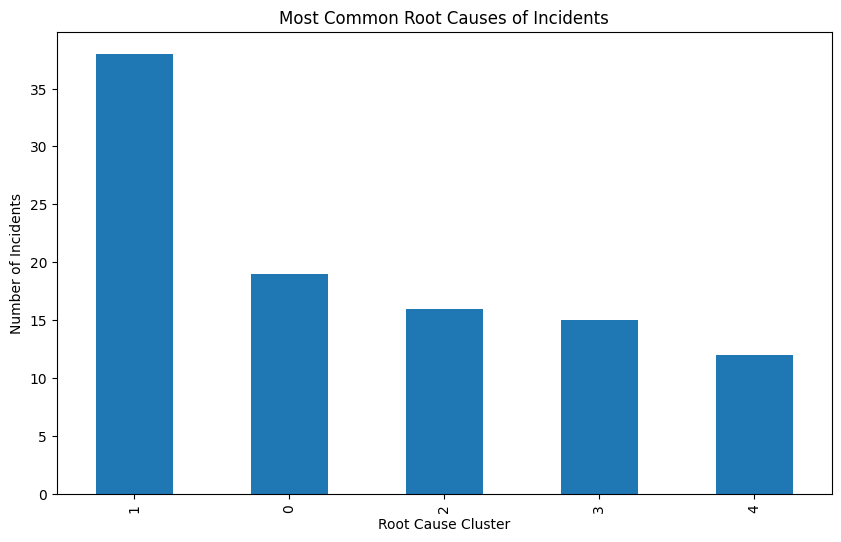

Cluster 0 keywords: ['bug', 'failure', 'network', 'outage', 'power', 'spam', 'issue']
Cluster 1 keywords: ['bug', 'failure', 'issue', 'outage', 'power', 'spam', 'network']
Cluster 2 keywords: ['failure', 'issue', 'network', 'outage', 'power', 'spam', 'bug']
Cluster 3 keywords: ['bug', 'issue', 'outage', 'power', 'spam', 'network', 'failure']
Cluster 4 keywords: ['bug', 'failure', 'issue', 'network', 'spam', 'outage', 'power']


In [71]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply KMeans clustering to root cause keywords
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(root_cause_tfidf)

# Add cluster labels to the original DataFrame
df_keywords['RootCauseCluster'] = clusters

# Analyze the distribution of root cause clusters
root_cause_cluster_counts = df_keywords['RootCauseCluster'].value_counts()

# Visualize the most common root causes
plt.figure(figsize=(10, 6))
root_cause_cluster_counts.plot(kind='bar')
plt.xlabel('Root Cause Cluster')
plt.ylabel('Number of Incidents')
plt.title('Most Common Root Causes of Incidents')
plt.show()

# Display cluster keywords
for i in range(n_clusters):
    cluster_center = kmeans.cluster_centers_[i]
    keywords_in_cluster = [root_cause_keywords[j] for j in cluster_center.argsort()[-10:]]
    print(f"Cluster {i} keywords: {keywords_in_cluster}")


                 OverallSeverity  HoursOfDowntime
OverallSeverity         1.000000         0.128191
HoursOfDowntime         0.128191         1.000000


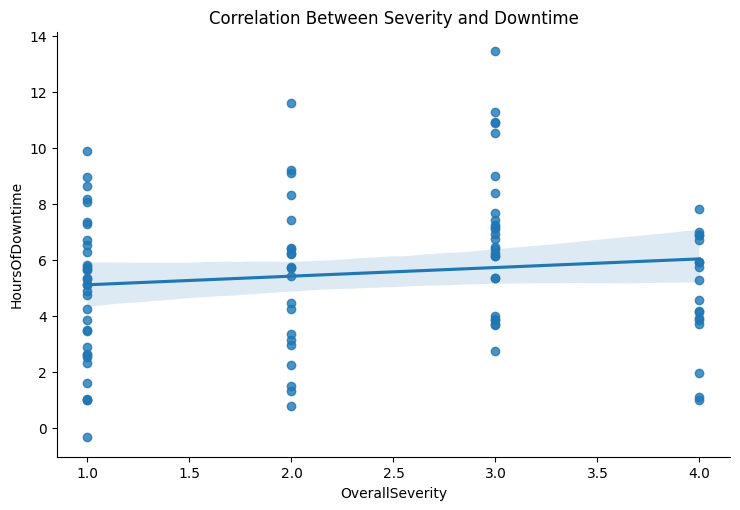

In [45]:
import seaborn as sns

# Calculate the correlation between OverallSeverity and HoursOfDowntime
severity_downtime_correlation = df_keywords[['OverallSeverity', 'HoursOfDowntime']].corr()
print(severity_downtime_correlation)

# Visualize the correlation
sns.lmplot(x='OverallSeverity', y='HoursOfDowntime', data=df_keywords, aspect=1.5)
plt.title('Correlation Between Severity and Downtime')
plt.show()
